In [15]:
from rake_nltk import Rake
from rouge import Rouge
import nltk
import pandas as pd
import re
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
test= pd.read_csv('cnn_dailymail/test.csv')

In [3]:
# Function to calculate word frequency in a text
def word_frequency(text):
    words = re.findall(r'\w+', text.lower())
    return Counter(words)

# Function to calculate RAKE scores for sentences in a text
def rake_scores(text):
    sentences = nltk.sent_tokenize(text)
    word_freq = word_frequency(text)
    word_degree = Counter()
    for sentence in sentences:
        unique_words = set(re.findall(r'\w+', sentence.lower()))
        for word in unique_words:
            word_degree[word] += len(unique_words)  # Increment degree by the number of unique words in the sentence
    
    # Calculate word scores based on frequency and degree
    word_scores = {word: degree / word_freq[word] for word, degree in word_degree.items()}

    # Calculate sentence scores
    sentence_scores = []
    for sentence in sentences:
        sentence_score = sum(word_scores.get(word, 0) for word in re.findall(r'\w+', sentence.lower()))
        sentence_scores.append((sentence_score, sentence))
    
    return sentence_scores

# Function to extract top RAKE sentences
def extract_top_rake_sentences(article, num_sentences):
    scores = rake_scores(article)
    top_sentences = sorted(scores, reverse=True)[:num_sentences]
    return [sentence for _, sentence in top_sentences]

In [4]:
rouge_scores = []
extact_sen = []
for index, row in test.iterrows():
    num_sentences = len(nltk.sent_tokenize(row['highlights']))
    top_sentences = extract_top_rake_sentences(row['article'], num_sentences)
    top_sentences_text = ' '.join(top_sentences)
    extact_sen.append(top_sentences_text)

In [5]:
test['extracted_sentence'] = extact_sen

In [6]:
test.head()

,id,article,highlights,extracted_sentence
0,92c514c913c0bdfe25341af9fd72b29db544099b,Ever noticed how plane seats appear to be gett...,Experts question if packed out planes are put...,"This week, a U.S consumer advisory group set u..."
1,2003841c7dc0e7c5b1a248f9cd536d727f27a45a,A drunk teenage boy had to be rescued by secur...,Drunk teenage boy climbed into lion enclosure ...,"Brave fool: Fortunately, Mr Kumar fell into a..."
2,91b7d2311527f5c2b63a65ca98d21d9c92485149,Dougie Freedman is on the verge of agreeing a ...,Nottingham Forest are close to extending Dougi...,Freedman has stabilised Forest since he replac...
3,caabf9cbdf96eb1410295a673e953d304391bfbb,Liverpool target Neto is also wanted by PSG an...,Fiorentina goalkeeper Neto has been linked wit...,It had been reported that Neto had a verbal ag...
4,3da746a7d9afcaa659088c8366ef6347fe6b53ea,Bruce Jenner will break his silence in a two-h...,"Tell-all interview with the reality TV star, 6...",His behavior over the past year also fueled sp...


In [7]:
rouge = Rouge()

# Function to calculate ROUGE-1 score
def calculate_rouge_score(system_summary, reference_summary):
    scores = rouge.get_scores(system_summary, reference_summary)
    return scores[0]['rouge-1']['f']  # F1-score of ROUGE-1

# Calculate ROUGE-1 scores for the simplified extracted sentences
test['rouge-1_score'] = test.apply(lambda row: calculate_rouge_score(row['extracted_sentence'], row['highlights']), axis=1)

# Display the first few rows along with their ROUGE-1 scores
test[['article', 'highlights', 'extracted_sentence', 'rouge-1_score']].head()

,article,highlights,extracted_sentence,rouge-1_score
0,Ever noticed how plane seats appear to be gett...,Experts question if packed out planes are put...,"This week, a U.S consumer advisory group set u...",0.381818
1,A drunk teenage boy had to be rescued by secur...,Drunk teenage boy climbed into lion enclosure ...,"Brave fool: Fortunately, Mr Kumar fell into a...",0.468468
2,Dougie Freedman is on the verge of agreeing a ...,Nottingham Forest are close to extending Dougi...,Freedman has stabilised Forest since he replac...,0.268293
3,Liverpool target Neto is also wanted by PSG an...,Fiorentina goalkeeper Neto has been linked wit...,It had been reported that Neto had a verbal ag...,0.318182
4,Bruce Jenner will break his silence in a two-h...,"Tell-all interview with the reality TV star, 6...",His behavior over the past year also fueled sp...,0.430769


In [8]:
avg_rouge1 = test['rouge-1_score'].mean()
print(avg_rouge1)

0.262922109916191


In [9]:
def calculate_rouge2_score(system_summary, reference_summary):
    scores = rouge.get_scores(system_summary, reference_summary)
    return scores[0]['rouge-2']['f']  # F1-score of ROUGE-2

# Calculate ROUGE-1 scores for the simplified extracted sentences
test['rouge-2_score'] = test.apply(lambda row: calculate_rouge2_score(row['extracted_sentence'], row['highlights']), axis=1)

# Display the first few rows along with their ROUGE-2 scores
test[['article', 'highlights', 'extracted_sentence', 'rouge-2_score']].head()

avg_rouge2 = test['rouge-2_score'].mean()
print(avg_rouge2)

0.08431347374622905


In [10]:
def calculate_rougel_score(system_summary, reference_summary):
    scores = rouge.get_scores(system_summary, reference_summary)
    return scores[0]['rouge-l']['f']  # F1-score of ROUGE-l

# Calculate ROUGE-1 scores for the simplified extracted sentences
test['rouge-l_score'] = test.apply(lambda row: calculate_rougel_score(row['extracted_sentence'], row['highlights']), axis=1)

# Display the first few rows along with their ROUGE-l scores
test[['article', 'highlights', 'extracted_sentence', 'rouge-l_score']].head()

avg_rougel = test['rouge-l_score'].mean()
print(avg_rougel)

0.23859172243431656


In [13]:
test['article_length'] = test['article'].apply(lambda x: len(x.split()))

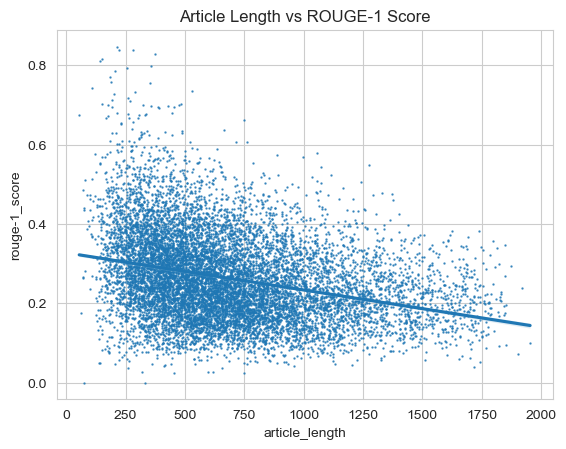

In [20]:
sns.regplot(x=test['article_length'], y=test['rouge-1_score'], scatter_kws={'s': 0.5})
plt.title('Article Length vs ROUGE-1 Score')
plt.show()

In [21]:
test['human_summary_length'] = test['highlights'].apply(lambda x: len(x.split()))

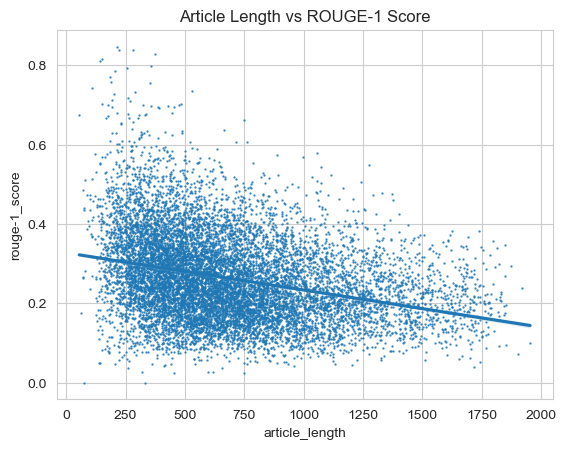

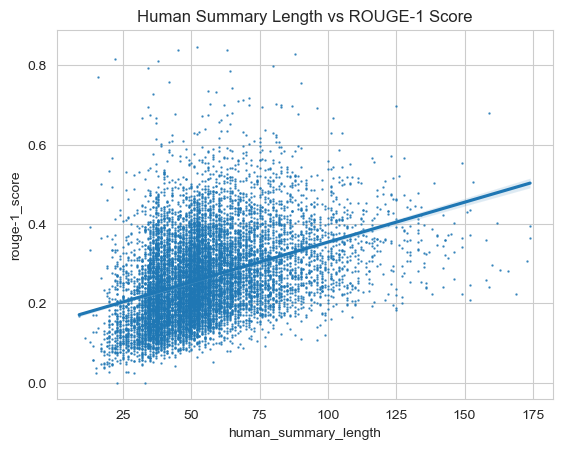

In [28]:
temp = test[test['human_summary_length'] < 175]
sns.regplot(x=temp['human_summary_length'], y=temp['rouge-1_score'], scatter_kws={'s': 0.5})
plt.title('Human Summary Length vs ROUGE-1 Score')
plt.show()